# Obligatorio de Deep Learning: Detección de actividad anormal en logs de HDFS

Federico De León (252047) 
Daniel Dominitz (62225) 
Juan Emilio Gabito (138616)

El presente trabajo obligatorio tiene como objetivo la clasificación de secuencias de log de un HDFS en NORMALES y ANORMALES. 

Esta notebook presenta todo el código desarrollado para realizar el análisis y exploración de los datos; la construcción, entranemiento y evaluación de distintas arquitecturas de redes neuronales recurrentes y técnicas de búsqueda de parámetros y regularización. A su vez se presenta como documentación del trabajo resultante.

A lo largo de este trabajo presentaremos las siguientes arquitecturas:

* Baseline presentada por el cuerpo docente
* Modelo Mejorado basado en el baseline
* Modelo Mejorado en el cual se aplican hiperparámetros obtenidos mediante *grid search*
* Modelo Mejorado sobre el cual se aplica  *batch normalization* en base a los hiperparámetros obtenidos mediante *grid search*
* Modelo Mejorado entrenado con datos generados mediante *data augmentation* en base a los hiperparámetros obtenidos mediante *grid search*
* Modelo Mejorado regularizado mediante *gradient clipping* en base a los hiperparámetros obtenidos mediante *grid search*
* Modelo Mejorado regularizado mediante *gradient normalization* en base a los hiperparámetros obtenidos mediante *grid search*
* Modelo Mejorado regularizado mediante *gradient normalization* entrenado con datos generados mediante *data augmentation* en base a los hiperparámetros obtenidos mediante *grid search*
* Modelo Mejorado sobre el cual se aplica  *batch normalization* regularizado mediante *gradient normalization* en base a los hiperparámetros obtenidos mediante *grid search*

En el desarrollo del obligatorio se irán aplicando los distintos conceptos aprendidos en el curso.

Finalmente se presentarán las conclusiones y reflexiones finales del trabajo.

## 1. Setup

### Imports

In [1]:
# Si estamos en Colab setemos Drive como FS
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Para Colab nos paramos en alguna de las carpetas del grupo
import os
if os.path.exists("/content/drive/MyDrive/ORT/DeepLearning/Obligatorio"):
  os.chdir('/content/drive/MyDrive/ORT/DeepLearning/Obligatorio')
else:
  if os.path.exists("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio"):
    os.chdir("/content/drive/MyDrive/ORT/Posgrado AI/Taller DeepLearning/Obligatorio")

In [3]:
import numpy as np
import datetime as dt
import math
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Dropout, Embedding, LSTM, Dense, BatchNormalization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from importlib import reload
import utils
utils = reload(utils)

import pandas as pd

### Reproducibilidad y repetibilidad

Para poder asegurar la reproducibilidad y repetibilidad de los experimentos en distintas ejecuciones seteamos la _seed_ tanto en Numpy como en Tensorflow.

In [4]:
np.random.seed(117)
tf.random.set_seed(117)

## 2. Carga de datos

In [5]:
hdfs_train, hdfs_test_kaggle = utils.read_data()

In [6]:
hdfs_train[:4]

id                                           sequence   class
0   0  (4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...  normal
1   1  (4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...  normal
2   2  (21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...  normal
3   3  (21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...  normal

In [7]:
hdfs_test_kaggle[:5]

id                                           sequence
0   0     (21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25)
1   1  (4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...
2   2  (4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...
3   3  (4, 4, 4, 21, 10, 8, 10, 8, 25, 25, 25, 10, 8,...
4   4  (21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...

## 3. Análisis exploratorio de datos

### Análisis descriptivo general

In [8]:
hdfs_train.head()

id                                           sequence   class
0   0  (4, 4, 4, 21, 10, 8, 10, 8, 10, 8, 25, 25, 25,...  normal
1   1  (4, 4, 4, 21, 10, 8, 25, 10, 8, 10, 8, 25, 25,...  normal
2   2  (21, 4, 4, 4, 25, 25, 10, 8, 25, 10, 8, 10, 8,...  normal
3   3  (21, 4, 4, 4, 10, 8, 10, 8, 10, 8, 25, 25, 25,...  normal
4   4  (21, 4, 4, 4, 25, 25, 25, 10, 8, 10, 8, 10, 8,...  normal

In [9]:
LABELS = ['Normal', 'Abnormal']

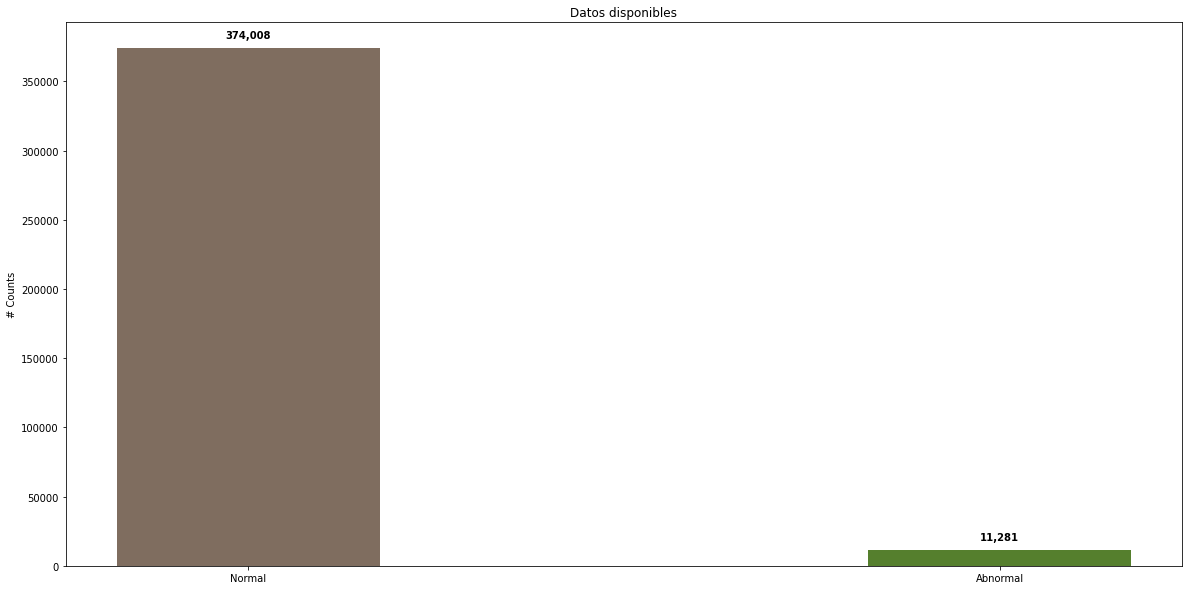

In [10]:
utils.plot_data(hdfs_train, LABELS, "Datos disponibles")

In [11]:
normal = hdfs_train['class'].value_counts()['normal']
value_cant = hdfs_train['class'].value_counts()
tot_cant = hdfs_train.shape[0]

In [12]:
value_cant

normal      374008
abnormal     11281
Name: class, dtype: int64

In [13]:
value_cant[0]/tot_cant*100

97.0720679801396

In [14]:
value_cant[1]/tot_cant*100

2.9279320198604166

### Análisis de secuencias

In [15]:
raw_sequences, data_y = utils.load_sequences_and_target(hdfs_train, one_hot=True)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
data_y.value_counts()

0    1  
0.0  1.0    374008
1.0  0.0     11281
dtype: int64

In [17]:
min([min(s) for s in raw_sequences])

1

In [18]:
max([max(s) for s in raw_sequences])

28

In [19]:
np.median([len(s) for s in raw_sequences])

19.0

In [20]:
np.mean([len(s) for s in raw_sequences])

19.420611540947185

En la siguiente gráfica se puede apreciar la distribución acumulada según el largo de cada instancia. Se puede ver que con largo menor a 50, se encuentran prácticamente el 100% de las raw sequences.

In [21]:
# get the cdf values of the len
y = np.arange(len([len(s) for s in raw_sequences])) / float(len([len(s) for s in raw_sequences]))

#fig size
plt.figure(figsize=(20,10)) 
#labels
plt.xlabel('Len raw sequences')
plt.ylabel('Distribution')
#title
plt.title('Cumulative Distribution Function of raw sequences')  
#plot 
plt.plot(np.sort([len(s) for s in raw_sequences]), y, marker='o')

# Preprocesamiento de los datos

Previo a realizar el preprocesamiento de los datos y el posterior entrenamiento y evaluación se los modelos setearemos la constante
_MAX\_LEN_ en 19. Este valor se obtuvo del largo promedio de las secuencias y en base a experimentación con
tamaños mayores y menores se pudo ver que 19 ofrecía los mejores resultados.

In [22]:
MAX_LEN = 19

## Padding

Las redes LSTM, como la que estamos usando en nuestros modelos, requieren que las secuencias que reciben como inputs sean del mismo largo, por lo tanto a las secuencias antes de ingresarlas al modelo se les debe realizar un padding para llevar a todos las secuencias dicho largo y poder cumplir con este requisito.

Hay dos formas de realizar el padding truncando los largos de las secuencias, una es ‘pre’ truncado, donde las secuencias son truncadas al principio, es decir que se toma la ultima parte de las secuencias de acuerdo al largo seleccionado, si la secuencia tiene 50 caracteres y el largo seleccionado es 19, se toman los últimos 19 caracteres de la secuencia. Las secuencias que tengan un largo menor al máximo largo elegido, se les agrega al principio un valor determinado para completar dicho largo, en este caso se las rellenó con el número ‘0’. La otra forma es truncándolas al final, ‘post’ truncado.

Para esta tarea decidimos realizar un padding con ‘pre’ truncado por entender o suponer que lo más lógico para determinar si una secuencia determinada es anormal, o en su defecto normal, pasaría al final de la misma.

En la funcion 'pad_sequences' del utils se realiza el truncado 'pre' al hacer el padding de las secuencias.

In [23]:
padded_sequences = utils.pad_sequences(raw_sequences, MAX_LEN)

## Particionamiento

In [24]:
X_train, X_test, X_val, y_train, y_test, y_val = utils.split(padded_sequences, data_y)

In [25]:
utils.plot_data(y_train, LABELS, "Datos de entrenamiento por clase", has_class=False)


## Generación de datos con Data Augmentation

La cantidad de datos que se disponen para entrenar un modelo afecta en gran medida el rendimiento de este, cuantos más datos tenemos mejores chances de obtener un modelo con buena performance. Una de las formas de agrandar el conjunto de datos es utilizando la técnica de data augmentation.

Algunas veces el overfitting es causado por tener muy pocas muestras de donde aprender por lo tanto siendo incapaz de entrenar al modelo para que pueda generalizar bien ante la presencia de datos nuevos.

Data augmentation es una técnica comúnmente utilizada para aumentar el tamaño del conjunto de datos para tareas de clasificación, la idea es generar más datos para entrenar el modelo a partir de las muestras existentes del set de training, aumentando las muestras a través de la realización de transformaciones que generen nuevas muestras creíbles. El objetivo es que al entrenar el modelo no vea nunca exactamente los mismos datos dos veces. Esto ayuda a exponer al modelo a una mayor cantidad de aspectos de los datos y lograr que generalice mejor con datos nuevos.

En nuestro caso, al tratarse de trazas de ejecuciones de logs, es muy importante mantener la secuencia en el tiempo de estos, por lo que optamos por utilizar la técnica de windowing para generar los datos nuevos, es decir que de los propias trazas que tenemos, tomamos ventanas con otros conjuntos de datos con los que el modelo no había sido entrenado.

Para esto decidimos tomar todas las secuencias que sean más largas que el tamaño máximo determinado por nosotros de 19, y agregarle a cada una de ellas , si su largo lo permitiera, tres nuevas ventanas tomando la que va desde el anteúltimo dato de la secuencia y sus 19 datos anteriores, la penúltima, y la antepenúltima, realizando para ello una nueva función ‘sequences_augmentation’ en el utils. De esta forma logramos obtener 200.000 secuencias nuevas de train que se agregaron a las 260.000 ya existentes.


In [26]:
X_train_for_aug, dummy_a, dummy_b, dummy_c, dummy_d, dummy_e = utils.split(raw_sequences, data_y)

In [27]:
# Fijamos la cantidad de ventanas para el data augmentation
WINDOWS = 3

In [28]:
X_train_aug, y_train_aug = utils.sequences_augmentation(X_train_for_aug, y_train, MAX_LEN, WINDOWS)

In [29]:
"""
padding to data augmentation train
"""
X_train_aug = utils.pad_sequences(X_train_aug, MAX_LEN)

In [30]:
utils.plot_data(y_train_aug, LABELS, "Datos de entrenamiento luego de Data Augmentation por clase", has_class=False)

# Redes Neuronales Recurrentes

Las redes neuronales recurrentes (RNN) son un tipo de arquitectura que tiene un componente que soluciona alguno de los problemas que presentes en MLP. Este es un componente de memoria interna que permite recordar información a medida que va pasando el tiempo. Este tipo de redes secuenciales reciben una entrada que es una secuencia para ser procesada que puede ser representada mediante un vector y un embeding que es una codificación de una estructura que transforma un input en un vector. Se llaman recurrentes porque toman el paso anterior para devolver el siguiente.

Problema de las RNN: a lo largo del tiempo a medida que se genera mucha cantidad de datos se empieza a penalizar este tipo de estructura, hecho que se resolvió con unas estructuras RNN más complejas como las LSTM (Long Short Term Memory) que se usan principalmente para series de tiempo y las GRU (Gated Recurrent Unit). Las GRU en algunos casos tienen ventajas sobre las LSTM, dado que usan menos memoria y son más rápidas, sin embargo LSTM son mejores cuando se usan datasets con secuencias largas. En nuestro caso vamos a utilizar las LSTM.

La función de costos que se va a utilizar va a depender del problema a resolver, si es un problema de clasificación multiclase se usara una *categorical crossentropy* que es la que vamos a utilizar en el caso de este trabajo.

## Modelo Inicial

In [31]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 10
epochs = 2
patience = 5
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

A continuación el modelo baseline lo vamos entrenar con los dos truncating mencionados en la sección Padding a modo de verificar, si es correcto o no, el supuesto que realizamos (usar truncating='pre').

### Truncating = 'Pre'

In [32]:
initial_model = Sequential()
initial_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model.add(LSTM(64, return_sequences=False))
initial_model.add(Dense(2, activation='softmax'))
initial_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 19, 3)             90        
                                                                 
 lstm (LSTM)                 (None, 64)                17408     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [33]:
initial_training, initial_model = utils.train(initial_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = None)

Epoch 1/2
26007/26007 [==============================] - 304s 12ms/step - loss: 0.0108 - accuracy: 0.9976 - val_loss: 0.0035 - val_accuracy: 0.9993
Epoch 2/2
26007/26007 [==============================] - 306s 12ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0024 - val_accuracy: 0.9996


#### Evaluación

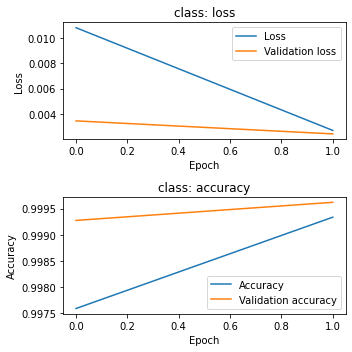

3011/3011 [==============================] - 14s 4ms/step


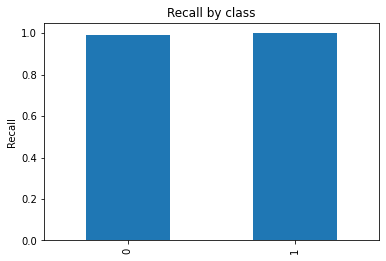

Classification report
              precision    recall  f1-score   support

    abnormal       0.99      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       1.00      0.99      1.00     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.0031198032665997744, accuracy: 0.9994289875030518


In [34]:
initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1 = utils.eval_model(initial_training, initial_model, X_test, y_test)

### Truncating = 'Post'

In [35]:
initial_model_post = Sequential()
initial_model_post.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
initial_model_post.add(LSTM(64, return_sequences=False))
initial_model_post.add(Dense(2, activation='softmax'))
initial_model_post.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
initial_model_post.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_1 (LSTM)               (None, 64)                17408     
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 17,628
Trainable params: 17,628
Non-trainable params: 0
_________________________________________________________________


#### Datos con padding al final

In [36]:
padded_sequences_post = utils.pad_sequences(raw_sequences, MAX_LEN,truncating='post')

In [37]:
X_train_post, X_test_post, X_val_post, y_train_post, y_test_post, y_val_post = utils.split(padded_sequences_post, data_y)

#### Entrenamiento

In [38]:
initial_training_post, initial_model_post = utils.train(initial_model_post,
                X_train_post,
                y_train_post, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val_post, 
                validation_data_y = y_val_post,                                
                patience = patience,
                class_weights = None)

Epoch 1/2
26007/26007 [==============================] - 303s 12ms/step - loss: 0.0480 - accuracy: 0.9890 - val_loss: 0.0400 - val_accuracy: 0.9919
Epoch 2/2
26007/26007 [==============================] - 309s 12ms/step - loss: 0.0383 - accuracy: 0.9921 - val_loss: 0.0383 - val_accuracy: 0.9922


#### Evaluación

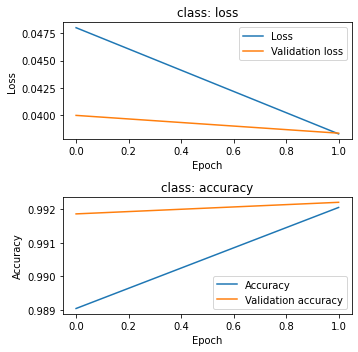

3011/3011 [==============================] - 14s 4ms/step


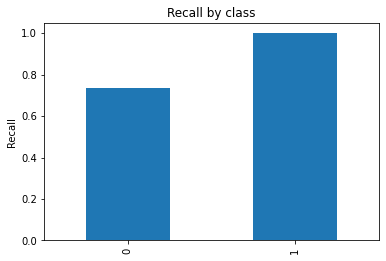

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.74      0.84      2901
      normal       0.99      1.00      1.00     93422

    accuracy                           0.99     96323
   macro avg       0.99      0.87      0.92     96323
weighted avg       0.99      0.99      0.99     96323

Loss function: 0.03904714435338974, accuracy: 0.9915804266929626


In [39]:
initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1 = utils.eval_model(initial_training_post, initial_model_post, X_test_post, y_test_post)

### Conclusiones Padding

En linea con lo que nosotros habiamos supuesto, en la siguiente tabla podemos ver que el modelo de mejor performance es el implementado con truncating='pre':

In [40]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model Pre Truncating',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Initial Model Post Truncating',initialmodel_post_accuracy, initialmodel_post_precision, initialmodel_post_recall, initialmodel_post_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='Recall', ascending=False)

Modelo  Accuracy  Precision  Recall  F1-score
0   Initial Model Pre Truncating   99.943%    99.552% 99.470%   99.511%
1  Initial Model Post Truncating   99.158%    98.583% 86.757%   91.800%

## Modelo Mejorado

In [41]:
vocab_size = max([max(s) for s in raw_sequences]) + 1
batch_size = 24
epochs = 7
patience = 5
optimizer = Adam() 
loss = 'categorical_crossentropy'
embedding_size = math.ceil(vocab_size**0.25) 

In [42]:
improved_model = Sequential()
improved_model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
improved_model.add(LSTM(64, return_sequences=True))
improved_model.add(LSTM(64, return_sequences=False))
improved_model.add(Dense(2, activation='softmax'))
improved_model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
improved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 19, 3)             90        
                                                                 
 lstm_2 (LSTM)               (None, 19, 64)            17408     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 50,652
Trainable params: 50,652
Non-trainable params: 0
_________________________________________________________________


### Entrenamiento

Balanceo de las clases - Class_weight

Como vimos en el análisis exploratorio de los datos, las clases estan desbalanceadas, por lo tanto lo primero que vamos a hacer al momento de entrenar los modelos es usar una técnica para ajustar los pesos de las clases.

Al usar un modelo de red neuronal para clasificar clases que no estan balanceadas, podemos ajustar el balance de los pesos para la función de costos y así darle mas atención o peso a la clase minoritaria. La librería Keras de python tiene una opción ya construida llamada class_weight para realizar esto de forma rápida. Uno de los beneficios de usar el ajuste de los pesos balanceados es que podemos usar los datos desbalanceados para construir el modelo directamente sin tener que utilizar técnicas de sub o sobremuestreo. La realización de este ajuste de los pesos mejoran significativamente la capacidad del modelo de capturar datos de la clase minoritaria.

Este ajuste se ve reflejado en la función 'train' de utils donde recibe 'class_weights' como uno de sus parámetros que a su vez hace un llamado a la función class_weights que utiliza la función preestablecida ‘compute_class_weight’ de la librería sklearn donde le damos la opcion ‘balanced’ para que realice el cálculo del balance automáticamente.


In [43]:
class_weights = utils.class_weights(hdfs_train,'class')
class_weights

{0: 17.076899211062848, 1: 0.5150812282090222}

Como podemos ver en el diccionario class_weights el modelo va a multiplicar por 17 a la clase minoritaria 'abnormal' y por 0.5 a las clase mayoritaria 'normal' para ajustar el desbalanceo de los datos.

In [44]:
improved_training, improved_model = utils.train(improved_model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/7
10837/10837 [==============================] - 264s 24ms/step - loss: 0.0499 - accuracy: 0.9922 - val_loss: 0.0087 - val_accuracy: 0.9989
Epoch 2/7
10837/10837 [==============================] - 258s 24ms/step - loss: 0.0153 - accuracy: 0.9981 - val_loss: 0.0189 - val_accuracy: 0.9965
Epoch 3/7
10837/10837 [==============================] - 259s 24ms/step - loss: 0.0192 - accuracy: 0.9969 - val_loss: 0.0054 - val_accuracy: 0.9988
Epoch 4/7
10837/10837 [==============================] - 261s 24ms/step - loss: 0.0130 - accuracy: 0.9984 - val_loss: 0.0077 - val_accuracy: 0.9988
Epoch 5/7
10837/10837 [==============================] - 258s 24ms/step - loss: 0.0109 - accuracy: 0.9987 - val_loss: 0.0041 - val_accuracy: 0.9993
Epoch 6/7
10837/10837 [==============================] - 259s 24ms/step - loss: 0.0097 - accuracy: 0.9989 - val_loss: 0.0067 - val_accuracy: 0.9987
Epoch 7/7
10837/10837 [==============================] - 259s 24ms/step - loss: 0.0101 - accuracy: 0.9990 - val_

### Evaluación

In [45]:
improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1 = utils.eval_model(improved_training, improved_model, X_test, y_test)

3011/3011 [==============================] - 27s 9ms/step


Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.005752459168434143, accuracy: 0.9987126588821411


## Grid Search



 En cualquier tarea de aprendizaje automático y en particular en deep learning el tuneo de hiperparámetros es una etapa fundamental del proceso de desarrollo, entrenamiento, validación y comparación de los modelos.

Dada la gran cantidad de hiperparámetros que puede ser configurada y los tiempos de entrenamiento de los modelos hacer una búsqueda exhaustiva es poco práctico se puede optar por dos mecanismos de búsqueda, *random search* y *grid search*. Para este trabajo y en base a lo solicitado haremos *grid search* probando los siguientes hiperparámetros:

*	batch_size de 16 y 32
*	epochs, 2, 8 y 15
*	units, 2, 64 y 72

Estos umbrales se definieron en base a distintas ejecuciones del modelo base. Cabe destacar que si bien se podrían haber sumado más valores, cada entrenamiento demoraba en el entorno de las 18 horas por lo cuál se optó por esta cantidad de valores distintos.

El siguiente JSON muestra el diccionario de parámetros utilizado para el entrenamiento del modelo.

```json
params = {   
	"batch_size": [16, 32],   
	"epochs": [2, 8, 15],   
	"units": [2, 64, 72],   
	"vocab_size": [vocab_size + 1,],   
	"embedding_size": [embedding_size,],   
	"max_len": [max_len,],   
	"optimizer": ["adam",],   
	"loss": ["categorical_crossentropy",]   
}
```

Algunos de los parámetros tienen valores fijos ya que los mismos serán los mismos para las distintas iteraciones: parámetros asociados al tamaño del vocabulario y el emebdding y los parámetros del optimizador y la loss.

La implementación particular de *grid search* puede ser encontrada en el archivo *utils.py*. Para ella usamos la clase *GridSearchCV* de sklearn que además de permitir hacer la búsqueda de los hiperparámetros también permite hacer *cross validation* usando *K-folds*. En nuestro caso usamos 3 folds. También usamos el wrapper *KerasClassifier* para poder empaquetar el modelo y que *GridSearchCV* sea capaz de entrenar el modelo con los distintos hiperparámetros que le fueron establecidos.

A continuación se muestra el resultado de la búsqueda de los hiperparámetros, el resultado de la misma y la selección de los mejores.


In [46]:
vocab_size = 30
patience = 5
embedding_size=3

params = {
    "batch_size": [16, 32],
    "epochs": [2, 8, 15],
    "units": [2,64, 72],
    "vocab_size": [vocab_size + 1,],
    "embedding_size": [embedding_size],
    "max_len": [MAX_LEN,],
    "optimizer": ["adam",],
    "loss": ["categorical_crossentropy",]
}

In [ ]:
"""
Entrenamiento
"""
gs = utils.grid_search(params, utils.build_improved_model, 3)
grid_result = gs.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Para obtener los mejores parámetros resultantes de la búsqueda se accede al atributo *best_params_* del objeto resultante:

In [48]:
grid_result.best_params_ 

{'batch_size': 32,
 'embedding_size': 3,
 'epochs': 15,
 'loss': 'categorical_crossentropy',
 'max_len': 19,
 'optimizer': 'adam',
 'units': 72,
 'vocab_size': 31}

A continuación se muestra el score resultante de la búsqueda de hipeparámetros.

In [ ]:
grid_result.best_score_

0.9997039238611857

In [49]:
batch_size = grid_result.best_params_['vocab_size']
epochs = grid_result.best_params_['epochs']
units = grid_result.best_params_['units']
optimizer = Adam() 
loss = grid_result.best_params_['loss']

### Model Mejorado 

In [50]:
model = Sequential()
model.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
model.add(LSTM(units, return_sequences=True))
model.add(LSTM(units, return_sequences=False))
model.add(Dense(2, activation='softmax'))
model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_4 (LSTM)               (None, 19, 72)            21888     
                                                                 
 lstm_5 (LSTM)               (None, 72)                41760     
                                                                 
 dense_3 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,887
Trainable params: 63,887
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [51]:
training, model = utils.train(model,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 245s 29ms/step - loss: 0.0477 - accuracy: 0.9921 - precision: 0.9921 - recall: 0.9921 - val_loss: 0.0092 - val_accuracy: 0.9984 - val_precision: 0.9984 - val_recall: 0.9984
Epoch 2/15
8390/8390 [==============================] - 238s 28ms/step - loss: 0.0174 - accuracy: 0.9968 - precision: 0.9968 - recall: 0.9968 - val_loss: 0.0193 - val_accuracy: 0.9963 - val_precision: 0.9963 - val_recall: 0.9963
Epoch 3/15
8390/8390 [==============================] - 239s 29ms/step - loss: 0.0195 - accuracy: 0.9969 - precision: 0.9969 - recall: 0.9969 - val_loss: 0.0124 - val_accuracy: 0.9983 - val_precision: 0.9983 - val_recall: 0.9983
Epoch 4/15
8390/8390 [==============================] - 241s 29ms/step - loss: 0.0132 - accuracy: 0.9980 - precision: 0.9980 - recall: 0.9980 - val_loss: 0.0101 - val_accuracy: 0.9962 - val_precision: 0.9962 - val_recall: 0.9962
Epoch 5/15
8390/8390 [==============================] - 241s 29ms/step - loss: 0.010

#### Evaluación

3011/3011 [==============================] - 29s 9ms/step


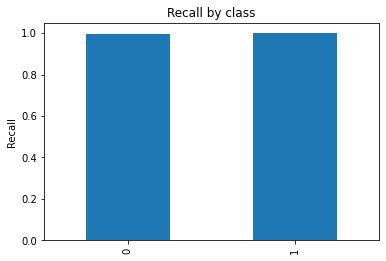

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004199494607746601, accuracy: 0.9987126588821411


In [52]:
model_accuracy, model_precision, model_recall, model_f1 = utils.eval_model(training, model, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [53]:
name='model'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(model, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = model.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 56s 9ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization

Segun Browlee: Batch Normalization (BN) es una técnica para entrenar redes neuronales muy profundas que estandariza las entradas a cada capa para cada mini batch. Esto tiene el efecto de estabilizar el proceso de aprendizaje y reducir drásticamente la cantidad de epochs en train necesarias para entrenar una red.

Los beneficios de aplicarla, son:
- Entrenamiento más rápido: aunque cada iteración será más lenta debido al cálculo de las normalizaciones aplicadas, se logra una convergencia mucho más rápida y por ende, el entrenamiento en términos generales debería de ser más rápido.
- Mayor learning rate: el descenso de gradiente, generalmente, requiere pequeñas tasas de aprendizaje para lograr llegar a una convergencia. A medida que las redes se vuelven más profundas, los gradientes se vuelven más pequeños durante la retropropagación y, por lo tanto, requieren aún más iteraciones. El uso de BN permite tasas de aprendizaje mucho más altas, lo que aumenta la velocidad de train.

- Inicializar los weights es más fácil: la inicialización de los weights es más difícil a medida que se crean redes más profundas. BN logra reducir la sensibilidad a los pesos iniciales.

Además de lo anterior, en algunos casos se logra una mejora en el rendimiento del modelo a través de un modesto efecto de regularización.

In [54]:
modelBN = Sequential()
modelBN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelBN.add(LSTM(units, return_sequences=True))
modelBN.add(LSTM(units, return_sequences=False))
modelBN.add(BatchNormalization())
modelBN.add(Dense(2, activation='softmax'))
modelBN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelBN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_6 (LSTM)               (None, 19, 72)            21888     
                                                                 
 lstm_7 (LSTM)               (None, 72)                41760     
                                                                 
 batch_normalization (BatchN  (None, 72)               288       
 ormalization)                                                   
                                                                 
 dense_4 (Dense)             (None, 2)                 146       
                                                                 
Total params: 64,175
Trainable params: 64,031
Non-trainable params: 144
________________________________________________

La implementación en Keras de BN consiste solo en agregar una layer en nuestro modelo y con esto, aplicamos una transformación que mantiene la salida media cercana a 0 y la desviación estándar de salida cercana a 1.

En nuestro caso y tal como se sugiere en el [paper original](https://arxiv.org/pdf/1502.03167.pdf), agregamos la layer de BN previo a la función de activación. Pero, tal como sugiere Brownlee hay algunos [experimentos](https://github.com/ducha-aiki/caffenet-benchmark/blob/master/batchnorm.md) que demuestran una mejor performance aplicándola luego de la función de activación. Nos quedó pendiente realizar el testeo en nuestro caso para determinar cual nos es más conveniente.

#### Entrenamiento

In [55]:
trainingBN, modelBN = utils.train(modelBN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 247s 29ms/step - loss: 0.0334 - accuracy: 0.9944 - precision_1: 0.9944 - recall_1: 0.9944 - val_loss: 0.0583 - val_accuracy: 0.9989 - val_precision_1: 0.9989 - val_recall_1: 0.9989
Epoch 2/15
8390/8390 [==============================] - 241s 29ms/step - loss: 0.0175 - accuracy: 0.9979 - precision_1: 0.9979 - recall_1: 0.9979 - val_loss: 0.0055 - val_accuracy: 0.9993 - val_precision_1: 0.9993 - val_recall_1: 0.9993
Epoch 3/15
8390/8390 [==============================] - 242s 29ms/step - loss: 0.0162 - accuracy: 0.9983 - precision_1: 0.9983 - recall_1: 0.9983 - val_loss: 0.0104 - val_accuracy: 0.9989 - val_precision_1: 0.9989 - val_recall_1: 0.9989
Epoch 4/15
8390/8390 [==============================] - 241s 29ms/step - loss: 0.0138 - accuracy: 0.9984 - precision_1: 0.9984 - recall_1: 0.9984 - val_loss: 0.0160 - val_accuracy: 0.9989 - val_precision_1: 0.9989 - val_recall_1: 0.9989
Epoch 5/15
8390/8390 [==============================

#### Evaluación

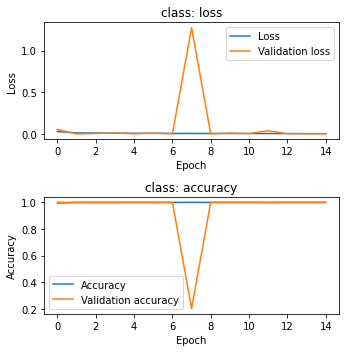

3011/3011 [==============================] - 28s 9ms/step


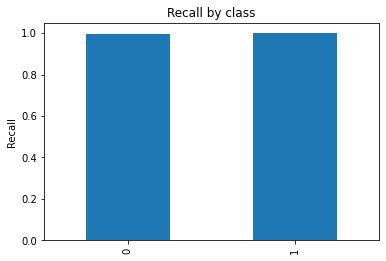

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.00670540239661932, accuracy: 0.9986919164657593


In [56]:
modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1 = utils.eval_model(trainingBN, modelBN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [57]:
name='ModelWithBN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelBN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelBN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelBN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 55s 9ms/step
Saved model to disk


### Modelo Mejorado con Gradient Clipping


Una de las desventajas de las RNNs es el exploding gradients (gradientes que crecen exponencialmente), esto se puede dar cuando los gradientes se vuelven muy grandes y los errores de los gradientes se acumulan resultando en una red inestable, y los vanishing gradientes (gradientes que disminuyen a valores cercanos a 0) puede ocurrir cuando la optimización se ve estancada en cierto punto debido a que el gradiente es demasiado chico para progresar. Una de las formas de prevenir estos problemas es la técnica de gradient clipping.

Una forma muy común de solucionar estos problemas es cambiar la derivada del error antes del back propagation a travez de la red y usarlo para actualizar los pesos. Dos aproximaciones son el escalado de los gradientes dado un vector determinado y el recorte de los valores del gradiente que exceden un rango dado. Juntos, esto métodos se denominan Gradient Clipping.

En nuestro caso utilizamos la técnica de gradient clipping con un clipvalue = 0.5, es decir que el gradiente se va a recortar entre los valores de -0.5 y 0.5. Se introdujo un umbral para que los gradientes que superan el valor de 0.5 se recortan a este valor, del mismo modo que los que sean menores a -0.5 se recorten a -0.5, esto evita que cualquier gradiente tenga un valor fuera de este rango. Hay un sesgo introducido en los valores resultantes del degradado, pero el gradient clipping puede mantener las cosas estables.

Este es un método que solo aborda la estabilidad numérica del entrenamiento de las redes pero no ofrece ninguna mejora en el rendimiento de las mismas.


In [58]:
optimizer = Adam(clipvalue=0.5) 

In [59]:
modelGC = Sequential()
modelGC.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGC.add(LSTM(units, return_sequences=True))
modelGC.add(LSTM(units, return_sequences=False))
modelGC.add(Dense(2, activation='softmax'))
modelGC.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGC.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_8 (LSTM)               (None, 19, 72)            21888     
                                                                 
 lstm_9 (LSTM)               (None, 72)                41760     
                                                                 
 dense_5 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,887
Trainable params: 63,887
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [60]:
trainingGC, modelGC = utils.train(modelGC,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 246s 29ms/step - loss: 0.0736 - accuracy: 0.9892 - precision_2: 0.9892 - recall_2: 0.9892 - val_loss: 0.0095 - val_accuracy: 0.9987 - val_precision_2: 0.9987 - val_recall_2: 0.9987
Epoch 2/15
8390/8390 [==============================] - 242s 29ms/step - loss: 0.0183 - accuracy: 0.9979 - precision_2: 0.9979 - recall_2: 0.9979 - val_loss: 0.0149 - val_accuracy: 0.9985 - val_precision_2: 0.9985 - val_recall_2: 0.9985
Epoch 3/15
8390/8390 [==============================] - 242s 29ms/step - loss: 0.0184 - accuracy: 0.9981 - precision_2: 0.9981 - recall_2: 0.9981 - val_loss: 0.0050 - val_accuracy: 0.9988 - val_precision_2: 0.9988 - val_recall_2: 0.9988
Epoch 4/15
8390/8390 [==============================] - 243s 29ms/step - loss: 0.0121 - accuracy: 0.9988 - precision_2: 0.9988 - recall_2: 0.9988 - val_loss: 0.0093 - val_accuracy: 0.9979 - val_precision_2: 0.9979 - val_recall_2: 0.9979
Epoch 5/15
8390/8390 [==============================

#### Evaluación

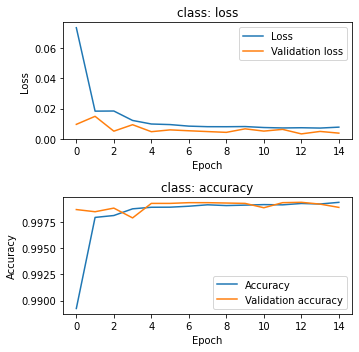

3011/3011 [==============================] - 30s 10ms/step


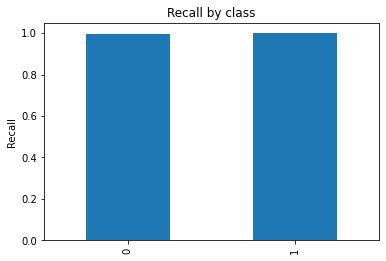

Classification report
              precision    recall  f1-score   support

    abnormal       0.96      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.98      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.004157017916440964, accuracy: 0.9986607432365417


In [61]:
modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1 = utils.eval_model(trainingGC, modelGC, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [62]:
name='ModelWithGC'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGC, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGC.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGC.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


5931/5931 [==============================] - 55s 9ms/step
Saved model to disk


### Modelo Mejorado con Gradient *Normalization*




Tal como se comenta en la documentación de [Keras](https://keras.io/api/optimizers/adam/), en el caso de Gradient Normalization la norma L2 de los gradientes es acotada a un valor específico. En nuestro y en base a lo visto en una [articulo de Brownlee](https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/), usamos el valor 1.

In [63]:
optimizer = Adam(clipnorm=1.)

In [64]:
modelGN = Sequential()
modelGN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN.add(LSTM(units, return_sequences=True))
modelGN.add(LSTM(units, return_sequences=False))
modelGN.add(Dense(2, activation='softmax'))
modelGN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_10 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_11 (LSTM)              (None, 72)                41760     
                                                                 
 dense_6 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,887
Trainable params: 63,887
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [65]:
trainingGN, modelGN = utils.train(modelGN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 250s 29ms/step - loss: 0.1446 - accuracy: 0.9840 - precision_3: 0.9840 - recall_3: 0.9840 - val_loss: 0.0132 - val_accuracy: 0.9983 - val_precision_3: 0.9983 - val_recall_3: 0.9983
Epoch 2/15
8390/8390 [==============================] - 246s 29ms/step - loss: 0.0270 - accuracy: 0.9985 - precision_3: 0.9985 - recall_3: 0.9985 - val_loss: 0.0153 - val_accuracy: 0.9988 - val_precision_3: 0.9988 - val_recall_3: 0.9988
Epoch 3/15
8390/8390 [==============================] - 247s 29ms/step - loss: 0.0205 - accuracy: 0.9987 - precision_3: 0.9987 - recall_3: 0.9987 - val_loss: 0.0081 - val_accuracy: 0.9988 - val_precision_3: 0.9988 - val_recall_3: 0.9988
Epoch 4/15
8390/8390 [==============================] - 245s 29ms/step - loss: 0.0170 - accuracy: 0.9988 - precision_3: 0.9988 - recall_3: 0.9988 - val_loss: 0.0069 - val_accuracy: 0.9988 - val_precision_3: 0.9988 - val_recall_3: 0.9988
Epoch 5/15
8390/8390 [==============================

#### Evaluación

3011/3011 [==============================] - 30s 10ms/step


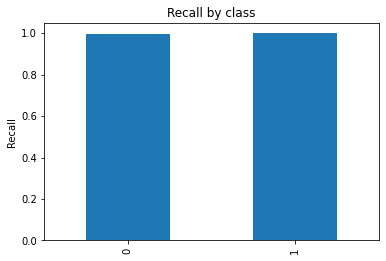

Classification report
              precision    recall  f1-score   support

    abnormal       0.97      0.99      0.98      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.003814506810158491, accuracy: 0.9989306926727295


In [66]:
modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1 = utils.eval_model(trainingGN, modelGN, X_test, y_test)

####Generación modelo y Salida Kaggle

In [67]:
name='ModelWithGN'

"""
Generate data Kaggle
"""
#generate kaggle
utils.load_test_sequences_and_generate_prediction_file(modelGN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")


5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


### Modelo Mejorado con Batch Normalization y Gradient Normalization

In [68]:
modelGN_BN = Sequential()
modelGN_BN.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelGN_BN.add(LSTM(units, return_sequences=True))
modelGN_BN.add(LSTM(units, return_sequences=False))
modelGN_BN.add(BatchNormalization())
modelGN_BN.add(Dense(2, activation='softmax'))
modelGN_BN.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_BN.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_12 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_13 (LSTM)              (None, 72)                41760     
                                                                 
 batch_normalization_1 (Batc  (None, 72)               288       
 hNormalization)                                                 
                                                                 
 dense_7 (Dense)             (None, 2)                 146       
                                                                 
Total params: 64,175
Trainable params: 64,031
Non-trainable params: 144
________________________________________________

#### Entrenamiento

In [69]:
trainingGN_BN, modelGN_BN = utils.train(modelGN_BN,
                X_train,
                y_train, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
8390/8390 [==============================] - 252s 29ms/step - loss: 0.0372 - accuracy: 0.9978 - precision_4: 0.9978 - recall_4: 0.9978 - val_loss: 4.6612 - val_accuracy: 0.0304 - val_precision_4: 0.0304 - val_recall_4: 0.0304
Epoch 2/15
8390/8390 [==============================] - 244s 29ms/step - loss: 0.0249 - accuracy: 0.9991 - precision_4: 0.9991 - recall_4: 0.9991 - val_loss: 0.0048 - val_accuracy: 0.9992 - val_precision_4: 0.9992 - val_recall_4: 0.9992
Epoch 3/15
8390/8390 [==============================] - 245s 29ms/step - loss: 0.0239 - accuracy: 0.9990 - precision_4: 0.9990 - recall_4: 0.9990 - val_loss: 16.1115 - val_accuracy: 0.0277 - val_precision_4: 0.0277 - val_recall_4: 0.0277
Epoch 4/15
8390/8390 [==============================] - 246s 29ms/step - loss: 0.0271 - accuracy: 0.9992 - precision_4: 0.9992 - recall_4: 0.9992 - val_loss: 2.9665 - val_accuracy: 0.0302 - val_precision_4: 0.0302 - val_recall_4: 0.0302
Epoch 5/15
8390/8390 [=============================

#### Evaluación

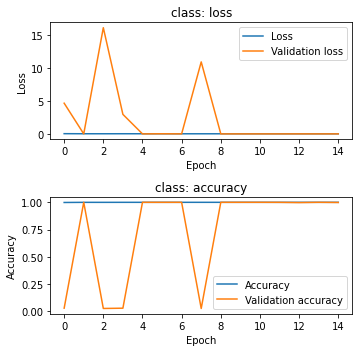

3011/3011 [==============================] - 29s 9ms/step


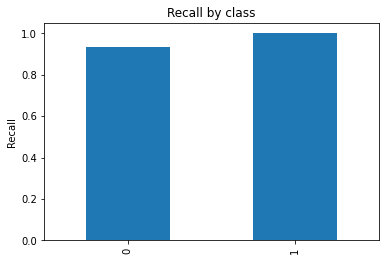

Classification report
              precision    recall  f1-score   support

    abnormal       0.99      0.93      0.96      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       1.00      0.97      0.98     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.008764299564063549, accuracy: 0.9978302121162415


In [70]:
modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1 = utils.eval_model(trainingGN_BN, modelGN_BN, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [71]:
name='ModelWithGNandBN'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_BN, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_BN.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_BN.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation

In [72]:
modelDA = Sequential()
modelDA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN))
modelDA.add(LSTM(units, return_sequences=True))
modelDA.add(LSTM(units, return_sequences=False))
modelDA.add(Dense(2, activation='softmax'))
modelDA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelDA.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_14 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_15 (LSTM)              (None, 72)                41760     
                                                                 
 dense_8 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,887
Trainable params: 63,887
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [73]:
trainingDA, modelDA = utils.train(modelDA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
14850/14850 [==============================] - 431s 29ms/step - loss: 0.2395 - accuracy: 0.9865 - precision_5: 0.9865 - recall_5: 0.9865 - val_loss: 0.1040 - val_accuracy: 0.9992 - val_precision_5: 0.9992 - val_recall_5: 0.9992
Epoch 2/15
14850/14850 [==============================] - 424s 29ms/step - loss: 0.2089 - accuracy: 0.9935 - precision_5: 0.9935 - recall_5: 0.9935 - val_loss: 0.0997 - val_accuracy: 0.9963 - val_precision_5: 0.9963 - val_recall_5: 0.9963
Epoch 3/15
14850/14850 [==============================] - 427s 29ms/step - loss: 0.2042 - accuracy: 0.9933 - precision_5: 0.9933 - recall_5: 0.9933 - val_loss: 0.0929 - val_accuracy: 0.9989 - val_precision_5: 0.9989 - val_recall_5: 0.9989
Epoch 4/15
14850/14850 [==============================] - 426s 29ms/step - loss: 0.2022 - accuracy: 0.9902 - precision_5: 0.9902 - recall_5: 0.9902 - val_loss: 0.0955 - val_accuracy: 0.9988 - val_precision_5: 0.9988 - val_recall_5: 0.9988
Epoch 5/15
14850/14850 [====================

#### Evaluación

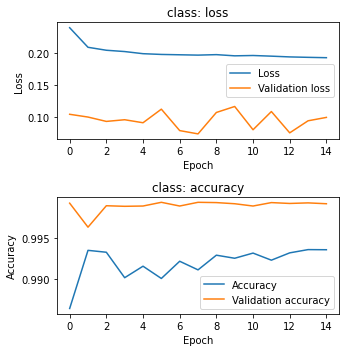

3011/3011 [==============================] - 29s 9ms/step


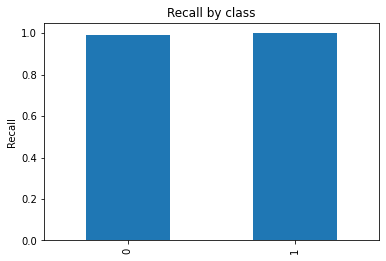

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.0988328605890274, accuracy: 0.9991175532341003


In [74]:
modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1 = utils.eval_model(trainingDA, modelDA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [75]:
name='ModelWithDataAugmentation'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelDA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelDA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelDA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 55s 9ms/step
Saved model to disk


### Modelo Mejorado con Data Augmentation y Gradient Normalization 

In [76]:
optimizer = Adam(clipnorm=1.) #para agregar clip value clipvalue=0.5

In [77]:
modelGN_DA = Sequential()
modelGN_DA.add(Embedding(vocab_size+1, embedding_size, input_length=MAX_LEN)) 
modelGN_DA.add(LSTM(units, return_sequences=True))
modelGN_DA.add(LSTM(units, return_sequences=False))
modelGN_DA.add(Dense(2, activation='softmax'))
modelGN_DA.compile(loss=loss, optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
modelGN_DA.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 19, 3)             93        
                                                                 
 lstm_16 (LSTM)              (None, 19, 72)            21888     
                                                                 
 lstm_17 (LSTM)              (None, 72)                41760     
                                                                 
 dense_9 (Dense)             (None, 2)                 146       
                                                                 
Total params: 63,887
Trainable params: 63,887
Non-trainable params: 0
_________________________________________________________________


#### Entrenamiento

In [78]:
trainingGN_DA, modelGN_DA = utils.train(modelGN_DA,
                X_train_aug,
                y_train_aug, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = X_val, 
                validation_data_y = y_val,                                
                patience = patience,
                class_weights = utils.class_weights(hdfs_train,'class'))

Epoch 1/15
14850/14850 [==============================] - 440s 29ms/step - loss: 0.2466 - accuracy: 0.9869 - precision_6: 0.9869 - recall_6: 0.9869 - val_loss: 0.1060 - val_accuracy: 0.9990 - val_precision_6: 0.9990 - val_recall_6: 0.9990
Epoch 2/15
14850/14850 [==============================] - 439s 30ms/step - loss: 0.2165 - accuracy: 0.9918 - precision_6: 0.9918 - recall_6: 0.9918 - val_loss: 0.0993 - val_accuracy: 0.9987 - val_precision_6: 0.9987 - val_recall_6: 0.9987
Epoch 3/15
14850/14850 [==============================] - 437s 29ms/step - loss: 0.2085 - accuracy: 0.9927 - precision_6: 0.9927 - recall_6: 0.9927 - val_loss: 0.0903 - val_accuracy: 0.9987 - val_precision_6: 0.9987 - val_recall_6: 0.9987
Epoch 4/15
14850/14850 [==============================] - 438s 29ms/step - loss: 0.2018 - accuracy: 0.9917 - precision_6: 0.9917 - recall_6: 0.9917 - val_loss: 0.0907 - val_accuracy: 0.9993 - val_precision_6: 0.9993 - val_recall_6: 0.9993
Epoch 5/15
14850/14850 [====================

#### Evaluación

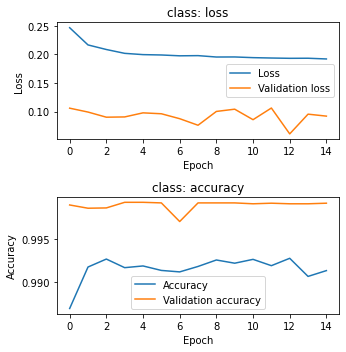

3011/3011 [==============================] - 29s 9ms/step


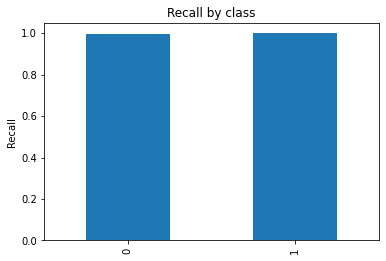

Classification report
              precision    recall  f1-score   support

    abnormal       0.98      0.99      0.99      2901
      normal       1.00      1.00      1.00     93422

    accuracy                           1.00     96323
   macro avg       0.99      1.00      0.99     96323
weighted avg       1.00      1.00      1.00     96323

Loss function: 0.09232813119888306, accuracy: 0.9991382956504822


In [79]:
modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1 = utils.eval_model(trainingGN_DA, modelGN_DA, X_test, y_test)

#### Generación modelo y Salida Kaggle

In [80]:
name='ModelWithDataAugmentationAndGradientNormalization'

"""
Generate data Kaggle
"""

utils.load_test_sequences_and_generate_prediction_file(modelGN_DA, hdfs_test_kaggle, MAX_LEN, name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs) )

"""
Generate Model
"""
# serialize model to JSON
model_json = modelGN_DA.to_json()
with open("outputs/model_"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
modelGN_DA.save_weights("outputs/model_Weigths"+name+'_maxLen'+str(MAX_LEN)+'_batchSize'+str(batch_size)+'_epochs'+str(epochs)+'_'+dt.datetime.today().strftime('%Y%m%d_%H%M%S')+".h5")
print("Saved model to disk")

5931/5931 [==============================] - 54s 9ms/step
Saved model to disk


## Conclusiones y reflexiones finales

A lo largo de este trabajo fuimos construyendo distintas arquitecturas que permitieron cumplir con las premisas planteadas en los requerimientos del obligatorio.
 
El trabajo no solo nos sirvió para profundizar en los distintos conceptos aprendidos en clase sino investigar técnicas adicionales como grid search, batch normalization, gradient clipping y gradient normalization.
 
Al momento de realizar el trabajo se optó por realizar ejecuciones con pocas epochs pero investigar todas las técnicas planteadas. ¿Por qué hicimos esto? Si bien la evidencia muestra que es posible lograr mejores resultados con una mayor cantidad de epochs entendimos que el trabajo presentaba la oportunidad de profundizar en las técnicas solicitadas. A esto se le suma los tiempos de entrenamiento que, para *grid search* rondaba el entorno de las 18 horas.
 
En cuanto a los modelos la siguiente tabla muestra los resultados finales obtenidos.

In [81]:
pd.options.display.float_format = '{:.3%}'.format
data = [['Initial Model',initialmodel_accuracy, initialmodel_precision, initialmodel_recall, initialmodel_f1], ['Improved Model',improved_model_accuracy, improved_model_precision, improved_model_recall, improved_model_f1], ['Improved Model Grid Search',model_accuracy, model_precision, model_recall, model_f1], ['Improved Model Grid Search with BN',modelBN_accuracy, modelBN_precision, modelBN_recall, modelBN_f1], ['Improved Model Grid Search with GC',modelGC_accuracy, modelGC_precision, modelGC_recall, modelGC_f1], ['Improved Model Grid Search with GN',modelGN_accuracy, modelGN_precision, modelGN_recall, modelGN_f1], ['Improved Model Grid Search with BN & GN',modelGN_BN_accuracy, modelGN_BN_precision, modelGN_BN_recall, modelGN_BN_f1], ['Improved Model Grid Search with DA',modelDA_accuracy, modelDA_precision, modelDA_recall, modelDA_f1], ['Improved Model Grid Search with DA & GN',modelGN_DA_accuracy, modelGN_DA_precision, modelGN_DA_recall, modelGN_DA_f1]]
pd.DataFrame(data, columns=["Modelo", "Accuracy", "Precision","Recall","F1-score"]).sort_values(by='Recall', ascending=False)

Modelo  Accuracy  Precision  Recall  \
5       Improved Model Grid Search with GN   99.893%    98.512% 99.694%   
2               Improved Model Grid Search   99.871%    98.172% 99.683%   
3       Improved Model Grid Search with BN   99.869%    98.140% 99.682%   
8  Improved Model Grid Search with DA & GN   99.914%    98.872% 99.672%   
1                           Improved Model   99.871%    98.202% 99.650%   
4       Improved Model Grid Search with GC   99.866%    98.122% 99.647%   
7       Improved Model Grid Search with DA   99.912%    98.870% 99.637%   
0                            Initial Model   99.943%    99.552% 99.470%   
6  Improved Model Grid Search with BN & GN   99.783%    99.568% 96.698%   

   F1-score  
5   99.096%  
2   98.915%  
3   98.898%  
8   99.269%  
1   98.915%  
4   98.872%  
7   99.251%  
0   99.511%  
6   98.088%

Puede apreciarse que para todos los modelos entrenados los resultados son satisfactorios. Si bien la diferencia entre ellos en términos generales está en las décimas, el modelo que obtuvo el mejor *recall* fue el mejorado usando *gradient normalization*.
 
Para este dataset y basándonos en el principio de la navaja de Occam nos quedamos con el modelo mejorado usando los hiperparámetros obtenidos mediante el *grid search*. La arquitectura de este modelo es relativamente simple y su costo de entrenamiento es bajo. A modo de experimento futuro se podría volver a entrenar este modelo usando una mayor cantidad de epochs.
 
En la misma línea el modelo baseline podría también ser entrenado con una gran cantidad de epochs (mayor a 2000). De todas formas entendemos que el objetivo pedagógico del trabajo no es tener modelos siendo entrenados durante horas sino comprender y aplicar los tópicos tratados en la materia y eso entendemos se ha logrado con éxito.

## Bibliogafìía y referencias

- https://towardsdatascience.com/batch-normalization-in-practice-an-example-with-keras-and-tensorflow-2-0-b1ec28bde96f
- https://machinelearningmastery.com/how-to-accelerate-learning-of-deep-neural-networks-with-batch-normalization/
- https://machinelearningmastery.com/how-to-avoid-exploding-gradients-in-neural-networks-with-gradient-clipping/
- https://towardsdatascience.com/data-augmentation-for-text-data-obtain-more-data-faster-525f7957acc9
- https://neptune.ai/blog/data-augmentation-nlp
- https://journalofbigdata.springeropen.com/articles/10.1186/s40537-021-00492-0
- https://towardsdatascience.com/text-augmentation-in-few-lines-of-python-code-cdd10cf3cf84
- https://machinelearningmastery.com/test-time-augmentation-with-scikit-learn/
- https://medium.com/analytics-vidhya/tabular-data-augmentation-with-deep-learning-7270584e7ff
- https://www.kaggle.com/questions-and-answers/80824
- https://medium.com/analytics-vidhya/data-augmentation-for-tabular-data-f75c94398c3e
- https://medium.com/analytics-vidhya/tabular-data-augmentation-with-deep-learning-7270584e7ff
- https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
- https://www.manning.com/books/deep-learning-with-python

